In [33]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from ast import literal_eval

In [62]:
scores_dir = 'scores'
segment_scores = 'SCORES_segments_experimental_set_with_reference.xlsx'
parameters_to_test = 'MAX'
RESULT_FILE = f'issues/{parameters_to_test}_{segment_scores}'

In [63]:
scores_df = pd.read_excel(f'{scores_dir}/{segment_scores}')
scores_df.head(2)

,source,reference,mt,subword_scores,wmt22-seqtag-mqm,corpus score,issues,type of issues
0,Many other things that the LHC could discover.,Коллайдер может открыть и много другого.,"Много других вещей, которые мог обнаружить БАК.","[('▁Много', 0.05214263126254082), ('▁других', ...",0.472122,0.032247,БАК,abbr
1,That's what the EIA forecast tells us.,Вот о чём говорит прогноз ИАЭ.,Вот что говорит нам прогноз EIA.,"[('▁Вот', 0.05699001997709274), ('▁что', 0.047...",0.519490,0.032247,EIA,abbr


In [64]:
scores_df['sentence_num'] = range(scores_df.shape[0])

In [65]:
scores_df.shape

(655, 9)

In [68]:
word_scores = scores_df['subword_scores']
word_scores_list = []
for segment_scores in word_scores:
    word_scores_list.append(literal_eval(segment_scores))

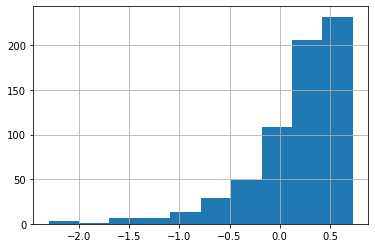

In [69]:
scores_df['wmt22-seqtag-mqm'].hist();

In [71]:
def extract_errors(word_scores):
    scores_new = []
    for index, pair in enumerate(word_scores):
        scores_new.append([index, pair])
    sorted_scores = scores_new
    errors = []
    weights = []
    for pair in sorted_scores:
        if pair not in (item for sublist in errors for item in sublist):
            if (pair[1][0].startswith('▁')) and (scores_new[pair[0]][0] != len(sorted_scores)-1) and (scores_new[pair[0]+1][1][0].startswith('▁')):
                errors.append(pair)
            else:
                if pair[1][0].startswith('▁'):
                    whole_word = []
                    whole_word.append(pair)
                    for i in range(1, 6):
                        if (pair[0]+i<len(sorted_scores)) and (scores_new[pair[0]+i][1][0].startswith('▁')==False):
                            whole_word.append(scores_new[pair[0]+i])
                        else:
                            errors.append(whole_word)
                            break
                else:
                    whole_word = []
                    whole_word.append(pair)
                    for i in range(1, 6):
                        if scores_new[pair[0]-i][1][0].startswith('▁'):
                            whole_word.insert(whole_word.index(pair)+1-i, scores_new[pair[0]-i])
                            break
                        else:
                            whole_word.insert(whole_word.index(pair)+1-i, scores_new[pair[0]-i])
                    for i in range(1, 6):
                        if pair[0]+i<len(sorted_scores):
                            if scores_new[pair[0]+i][1][0].startswith('▁'):
                                errors.append(whole_word)
                                break
                            else:
                                whole_word.append(scores_new[pair[0]+i])
                        else:
                            errors.append(whole_word)
                            break
        elif (pair[1][0].startswith('▁')) and (scores_new[pair[0]][0] == len(sorted_scores)-1):
            errors.append(pair)
        else:
            continue
    tokens = []
    all_weights = []
    for pair in errors:
        token = []
        weights = []
        if type(pair[0])==list:
            for p in pair:
                token.append(p[1][0])
                weights.append(p[1][1])
            tokens.append(''.join(token))
            if parameters_to_test == 'SUM':
                all_weights.append(sum(weights))
            elif parameters_to_test == 'MAX':
                all_weights.append(max(weights))
        else:
            tokens.append(pair[1][0])
            all_weights.append(pair[1][1])
    tokens_clean = [token.replace('▁', '') for token in tokens]
    return tokens_clean, all_weights

In [72]:
all_tokens = []
all_weights = []
sentence_num = []

In [73]:
for index, sentence in enumerate(word_scores_list):
    tokens, weights = extract_errors(sentence)
    for token, weight in zip(tokens, weights):
        all_tokens.append(token)
        all_weights.append(weight)
        sentence_num.append(index)

In [74]:
len(all_tokens)==len(all_weights)==len(sentence_num)

True

In [75]:
tokens_weights_df = pd.DataFrame(data={'tokens': all_tokens, 'weights': all_weights, 'sentence_num':sentence_num})

In [76]:
tokens_weights_df.head()

,tokens,weights,sentence_num
0,Много,0.052143,0
1,других,0.038244,0
2,"вещей,",0.098989,0
3,которые,0.032366,0
4,мог,0.140833,0


In [77]:
tokens_weights_df.shape

(9469, 3)

In [78]:
tokens_weights_df.sort_values(by='weights', ascending=False)[:50]

,tokens,weights,sentence_num
4885,(Audio-Follow-Video),5.139834,326
6663,Covid-пострадавших,5.016753,435
4839,Fade-Thru-Black,4.807242,324
4835,Fade-Thru-Black,4.679301,324
2543,парикмахерскую,4.326813,176
7776,Rollercoaster,4.285227,511
7754,Picture-in-Picture,4.148581,510
9409,#PRS_ORG#,3.594893,650
6681,О'Махони.,3.553739,435
4168,насторожить!,3.338533,283


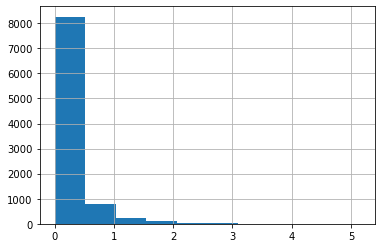

In [79]:
tokens_weights_df['weights'].hist();

### Select only sentences with tokens weights > 0.75 procentile

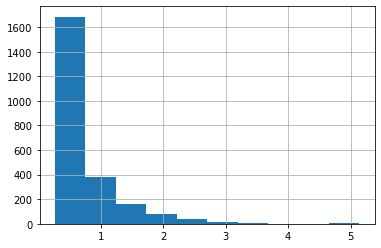

In [80]:
tokens_weights_df[tokens_weights_df['weights']>tokens_weights_df['weights'].quantile(0.75)]['weights'].hist();

In [81]:
print('Sentences with issues:')
len(tokens_weights_df[tokens_weights_df['weights']>tokens_weights_df['weights'].quantile(0.75)]['sentence_num'].unique().tolist())

Sentences with issues:


538

In [82]:
tokens_big_weights = tokens_weights_df[tokens_weights_df['weights']>tokens_weights_df['weights'].quantile(0.75)]

In [83]:
issues_df = scores_df[scores_df['sentence_num'].isin(tokens_big_weights['sentence_num'].unique().tolist())]
issues_df.shape

(538, 9)

In [84]:
issues_list = []
for index, row in issues_df.iterrows():
    temp_df = tokens_big_weights[tokens_big_weights['sentence_num']==row['sentence_num']]
    issues_list.append(temp_df['tokens'].to_list())

In [85]:
issues_df['issues_found'] = issues_list

<ipython-input-85-474b16002a51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  issues_df['issues_found'] = issues_list


## Save issues_df

In [86]:
issues_df.to_excel(RESULT_FILE, index=False)